<a href="https://colab.research.google.com/github/noorfatima640/water-quality-ml/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/water-quality-FINAL-cleaned.csv')
df.columns = df.columns.str.strip()

In [3]:
def score_do(val):
    return np.clip(20*val + 50, 0, 100)

def score_ph(val):
    ideal = 7.5
    return np.clip(100 - abs(val - ideal)*20, 0, 100)

def score_temp(t):
    return np.clip(100 - (t-20)*4, 0, 100)

def inverse_score(val, scale=50):
    return np.clip(100 - max(0, val*scale), 0, 100)

df["DO_score"] = df["DO"].apply(score_do)
df["pH_score"] = df["pH"].apply(score_ph)
df["Temp_score"] = df["Temperature"].apply(score_temp)
df["TotalN_score"] = df["Total_N"].apply(lambda x: inverse_score(x, scale=60))
df["Cond_score"] = df["Conductivity"].apply(lambda x: inverse_score(x, scale=40))
df["OrthoP_score"] = df["Orthophosphate"].apply(lambda x: inverse_score(x, scale=120))

weights = {
    "DO_score": 0.23,
    "pH_score": 0.23,
    "Temp_score": 0.18,
    "TotalN_score": 0.13,
    "Cond_score": 0.13,
    "OrthoP_score": 0.10,
}

df["WQI"] = (
    df["DO_score"] * weights["DO_score"] +
    df["pH_score"] * weights["pH_score"] +
    df["Temp_score"] * weights["Temp_score"] +
    df["TotalN_score"] * weights["TotalN_score"] +
    df["Cond_score"] * weights["Cond_score"] +
    df["OrthoP_score"] * weights["OrthoP_score"]
)


In [4]:
df = pd.get_dummies(df, columns=["Season"], drop_first=True)

In [5]:
chemicals = ["pH","DO","Conductivity","Temperature","Total_N","Orthophosphate"]
X_wqi = df[chemicals]
y_wqi = df["WQI"]

temp_features = [
    "pH","DO","Conductivity","Total_N","Orthophosphate",
    "WQI","Year","Month","Season_numerical",
    "Season_Spring","Season_Summer","Season_Winter"
]

X_temp = df[temp_features]
y_temp = df["Temperature"]

In [6]:
from sklearn.model_selection import train_test_split

X_train_wqi, X_test_wqi, y_train_wqi, y_test_wqi = train_test_split(
    X_wqi, y_wqi, test_size=0.2, random_state=42
)

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

In [7]:
!pip install lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [8]:
model_temp_lgbm = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

model_temp_lgbm.fit(X_train_temp, y_train_temp)

pred_temp = model_temp_lgbm.predict(X_test_temp)

rmse_temp = np.sqrt(mean_squared_error(y_test_temp, pred_temp))
r2_temp = r2_score(y_test_temp, pred_temp)

print("LightGBM Temperature RMSE:", rmse_temp)
print("LightGBM Temperature R² :", r2_temp)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1591
[LightGBM] [Info] Number of data points in the train set: 111184, number of used features: 12
[LightGBM] [Info] Start training from score 0.007702
LightGBM Temperature RMSE: 0.24115543821056307
LightGBM Temperature R² : 0.8886576216575333


In [9]:
model_wqi_lgbm = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

model_wqi_lgbm.fit(X_train_wqi, y_train_wqi)

pred_wqi = model_wqi_lgbm.predict(X_test_wqi)

rmse_wqi = np.sqrt(mean_squared_error(y_test_wqi, pred_wqi))
r2_wqi = r2_score(y_test_wqi, pred_wqi)

print("LightGBM WQI RMSE:", rmse_wqi)
print("LightGBM WQI R² :", r2_wqi)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1516
[LightGBM] [Info] Number of data points in the train set: 111184, number of used features: 6
[LightGBM] [Info] Start training from score 64.250600
LightGBM WQI RMSE: 0.15158279852921272
LightGBM WQI R² : 0.9990790257261878


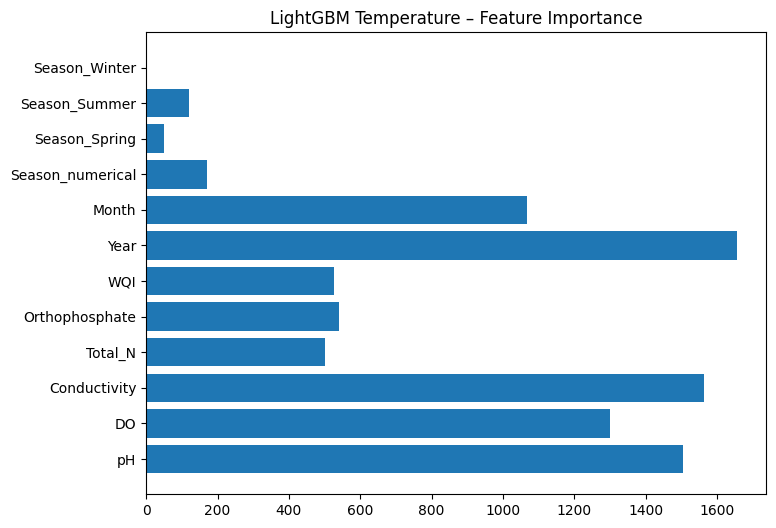

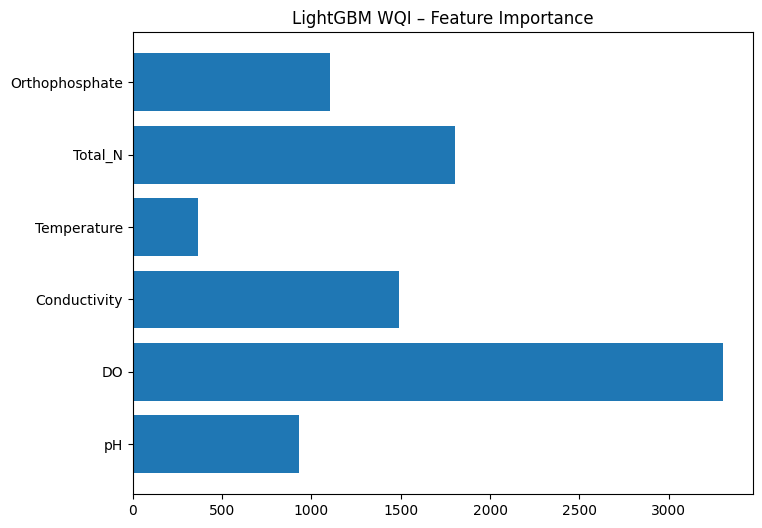

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(X_temp.columns, model_temp_lgbm.feature_importances_)
plt.title("LightGBM Temperature – Feature Importance")
plt.show()

plt.figure(figsize=(8,6))
plt.barh(X_wqi.columns, model_wqi_lgbm.feature_importances_)
plt.title("LightGBM WQI – Feature Importance")
plt.show()

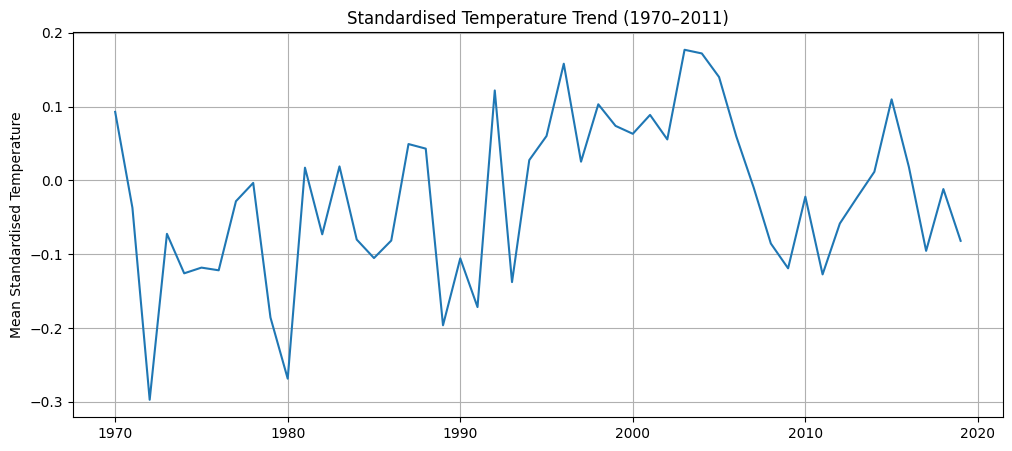

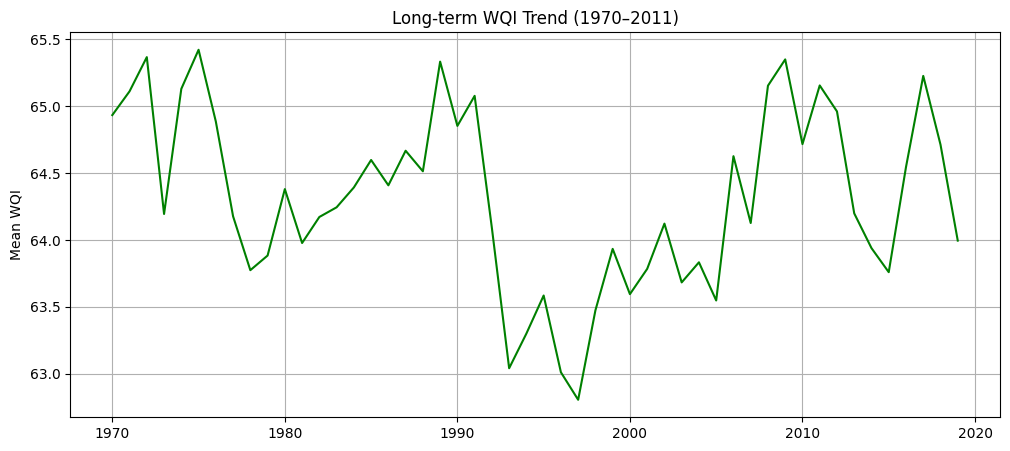

In [13]:
df_year = df.groupby("Year")["Temperature"].mean().reset_index()

plt.figure(figsize=(12,5))
plt.plot(df_year["Year"], df_year["Temperature"])
plt.title("Standardised Temperature Trend (1970–2011)")
plt.ylabel("Mean Standardised Temperature")
plt.grid(True)
plt.show()

df_year_wqi = df.groupby("Year")["WQI"].mean().reset_index()

plt.figure(figsize=(12,5))
plt.plot(df_year_wqi["Year"], df_year_wqi["WQI"], color="green")
plt.title("Long-term WQI Trend (1970–2011)")
plt.ylabel("Mean WQI")
plt.grid(True)
plt.show()

In [14]:
df[["Temperature", "WQI"]].corr()

,Temperature,WQI
Temperature,1.000000,-0.126737
WQI,-0.126737,1.000000
